In [1]:
from google.colab import drive
drive.mount('./drive')

Mounted at ./drive


In [2]:
import os 
from os import listdir
from tqdm import tqdm
import shutil
import cv2
import torch 
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.optim import lr_scheduler
import seaborn as sns

# Change of the data folders for having the right labels 

In [ ]:
PathDicom = "./drive/MyDrive/breast"
lstFilesDCM = [] 
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".png" in filename.lower():  
          if "40X" in dirName: 
            lstFilesDCM.append(os.path.join(dirName,filename))

In [ ]:
img = cv2.imread(files)
img.shape

(460, 700, 3)

In [ ]:
for files in lstFilesDCM:
  img = cv2.imread(files)
  if img.shape != (460, 700, 3):
    continue
  if "adenosis" in files:
    destination = os.path.join("./drive/MyDrive/8Cbreast40/adenosis",os.path.basename(files))
    shutil.copyfile(files, destination)
  elif "fibroadenoma" in files:
    destination = os.path.join("./drive/MyDrive/8Cbreast40/fibroadenoma",os.path.basename(files))
    shutil.copyfile(files, destination)
  elif "phyllodes_tumor" in files:
    destination = os.path.join("./drive/MyDrive/8Cbreast40/phyllodes_tumor",os.path.basename(files))
    shutil.copyfile(files, destination)
  elif "tubular_adenoma" in files:
    destination = os.path.join("./drive/MyDrive/8Cbreast40/tubular_adenoma",os.path.basename(files))
    shutil.copyfile(files, destination)
  elif "ductal_carcinoma" in files:
    destination = os.path.join("./drive/MyDrive/8Cbreast40/ductal_carcinoma",os.path.basename(files))
    shutil.copyfile(files, destination)
  elif "lobular_carcinoma" in files:
    destination = os.path.join("./drive/MyDrive/8Cbreast40/lobular_carcinoma",os.path.basename(files))
    shutil.copyfile(files, destination)
  elif "mucinous_carcinoma" in files:
    destination = os.path.join("./drive/MyDrive/8Cbreast40/mucinous_carcinoma",os.path.basename(files))
    shutil.copyfile(files, destination)
  elif "papillary_carcinoma" in files:
    destination = os.path.join("./drive/MyDrive/8Cbreast40/papillary_carcinoma",os.path.basename(files))
    shutil.copyfile(files, destination)


# Data importation

In [3]:
data40x = torchvision.datasets.ImageFolder("./drive/MyDrive/8Cbreast40")

In [5]:
class MapDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  
        y = self.dataset[index][1]      
        return x, y

    def __getlabel__(self,index):
        return self.dataset[index][1]
        
    def __len__(self):
        return len(self.dataset)

In [6]:
train_transform = transforms.Compose([
        transforms.RandomCrop(230),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.8023, 0.6521, 0.7710], [0.0916, 0.1192, 0.0908])
    ])

test_transform = torchvision.transforms.Compose([
        transforms.CenterCrop(230),
        transforms.ToTensor(),
        transforms.Normalize([0.8023, 0.6521, 0.7710], [0.0916, 0.1192, 0.0908])
    ])

final_transform = torchvision.transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.8023, 0.6521, 0.7710], [0.0916, 0.1192, 0.0908])
    ])
traindataset = MapDataset(data40x,train_transform)
valdataset = MapDataset(data40x,test_transform)
testdataset = MapDataset(data40x,final_transform)

dataset_size = 2003
indices = list(range(dataset_size))
split = int(np.floor(0.15 * dataset_size))

np.random.seed(1234)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

x_train = torch.utils.data.Subset(traindataset, indices=train_indices)
x_test = torch.utils.data.Subset(valdataset, indices=val_indices)
x_final = torch.utils.data.Subset(testdataset, indices=val_indices)

In [ ]:
target = np.zeros(round(0.85*(654+1349)))
for i in range(round(0.85*(654+1349))):
  target[i] = x_train[i][1]
target = target.astype(int)
torch.save(target,"./drive/MyDrive/8Cbreast40/targetTrain" )

In [8]:
target = torch.load("./drive/MyDrive/8Cbreast40/targetTrain" )


In [9]:
class_sample_count = np.array([len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count

samples_weight = np.array([weight[t] for t in target])

samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))

In [10]:
train_loader =  torch.utils.data.DataLoader(x_train, batch_size=32,sampler=sampler)
validation_loader =  torch.utils.data.DataLoader(x_test, batch_size=1, shuffle=False)
test_loader =  torch.utils.data.DataLoader(x_final, batch_size=1, shuffle=False)

# ResNet18

In [ ]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)
model.fc = nn.Linear(512, 8)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

val_acc = []
train_acc = []
train_loss = []
val_loss = []

num_epochs = 15
for i in range(num_epochs):
  model.train()
  ground_truthVal = []
  predVal = []
  c = 0
  for images, labels in train_loader:
        predTrain = []
        ground_truthTrain = []
        images, labels = images.float().to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)

        loss = loss_fn(outputs.to(device), labels.type(torch.LongTensor).to(device))
        loss.backward()
        optimizer.step()

        predicted = torch.argmax(outputs,dim=1)
        predTrain.extend(predicted.detach().cpu().numpy().flatten().tolist())
        ground_truthTrain.extend(labels.detach().cpu().numpy().flatten().tolist())

        c+=1
        if c%10 == 0:
          accuracy = accuracy_score(ground_truthTrain, predTrain)
          print('Epoch: {}. Loss: {}. Accuracy on trainset: {}'.format(i, loss.item(), accuracy))
  train_loss.append(loss.item())
  accuracy = accuracy_score(ground_truthTrain, predTrain)
  train_acc.append(accuracy)
  for images, labels in validation_loader:#validation
      model.eval()
      with torch.no_grad():
        images, labels = images.float().to(device), labels.to(device)
        
        outputs = model(images)

        predicted = torch.argmax(outputs,dim=1)
        predVal.extend(predicted.detach().cpu().numpy().flatten().tolist())
        ground_truthVal.extend(labels.detach().cpu().numpy().flatten().tolist())
      
  print(confusion_matrix(ground_truthVal,predVal))
  loss = loss_fn(outputs.to(device), labels.type(torch.LongTensor).to(device))
  val_loss.append(loss.item())
  accuracy = accuracy_score(ground_truthVal, predVal)
  val_acc.append(accuracy)
  print('Accuracy in validation: {}'.format(accuracy))
  exp_lr_scheduler.step()

torch.save(model.state_dict(),"./drive/MyDrive/8CResNet18" )











Epoch: 0. Loss: 2.012174367904663. Accuracy on trainset: 0.1875










Epoch: 0. Loss: 1.774189829826355. Accuracy on trainset: 0.40625










Epoch: 0. Loss: 1.6971797943115234. Accuracy on trainset: 0.3125










Epoch: 0. Loss: 1.487642526626587. Accuracy on trainset: 0.5










Epoch: 0. Loss: 1.3775643110275269. Accuracy on trainset: 0.5




[[15  0  1  0  3  0  1  1]
 [ 4 50  8 40  6  7  2 14]
 [ 1  2 12  1  2  0 16  1]
 [ 0  0  0 24  0  0  0  1]
 [ 3  4  1  3 10  3  1  2]
 [ 0  0  2  1  1  9  0  5]
 [ 3  1  1  1  0  1  8  1]
 [ 1  2  1  0  1  1  1 20]]
Accuracy in validation: 0.49333333333333335










Epoch: 1. Loss: 1.229763388633728. Accuracy on trainset: 0.59375










Epoch: 1. Loss: 0.9474428296089172. Accuracy on trainset: 0.6875










Epoch: 1. Loss: 1.0258687734603882. Accuracy on trainset: 0.65625










Epoch: 1. Loss: 1.0493059158325195. Accuracy on trainset: 0.53125










Epoch: 1. Loss: 0.6519249677658081. Accuracy on trainset

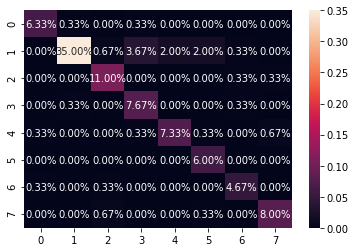

In [ ]:
cf_matrix = confusion_matrix(ground_truthVal,predVal)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')

In [ ]:
PATH="./drive/MyDrive/8CResNet34"
from torchvision.models import resnet34
model = resnet34()
model.fc = nn.Linear(512,8)
model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
val_acc = []
train_acc = []
train_loss = []
val_loss = []
ground_truthVal = []
predVal = []
device = "cpu"
for images, labels in validation_loader:#validation
    model.eval()
    with torch.no_grad():
      images, labels = images.float().to(device), labels.to(device)
      
      outputs = model(images)

      predicted = torch.argmax(outputs,dim=1)
      predVal.extend(predicted.detach().cpu().numpy().flatten().tolist())
      ground_truthVal.extend(labels.detach().cpu().numpy().flatten().tolist())

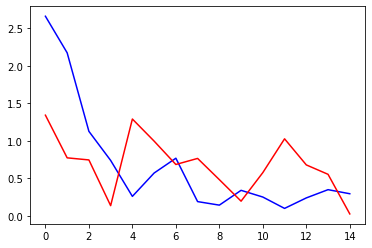

In [ ]:
plt.plot(np.arange(len(val_acc)),val_loss,color="blue")
plt.plot(np.arange(len(val_acc)),train_loss,color="red")

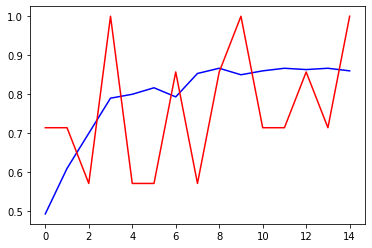

In [ ]:
plt.plot(np.arange(len(val_acc)),val_acc,color="blue")
plt.plot(np.arange(len(val_acc)),train_acc,color="red")

In [ ]:
model.to('cpu')
model.eval()
predVal = []
ground_truthVal = []

for images, labels in test_loader:
  res = torch.zeros(8)
  img1 = images[:,:,0:230,3:233]
  res = res + model(img1)
  img2 = images[:,:,230:460,3:233]
  res = res + model(img2)

  img3 = images[:,:,0:230,236:466]
  res = res + model(img3)
  img4 = images[:,:,230:460,236:466]
  res = res + model(img4)

  img5 = images[:,:,0:230,469:699]
  res = res + model(img5)
  img6 = images[:,:,230:460,469:699]
  res = res + model(img6)

  predicted = torch.argmax(res)
  predVal.extend(predicted.detach().cpu().numpy().flatten().tolist())
  ground_truthVal.extend(labels.detach().cpu().numpy().flatten().tolist())

print(confusion_matrix(ground_truthVal,predVal))
print(accuracy_score(ground_truthVal,predVal))

[[ 21   0   0   0   0   0   0   0]
 [  0 111   1   9   3   5   2   0]
 [  0   0  35   0   0   0   0   0]
 [  0   1   0  24   0   0   0   0]
 [  0   0   0   1  25   0   0   1]
 [  0   0   0   0   0  18   0   0]
 [  1   0   1   0   0   0  14   0]
 [  0   0   0   0   0   0   0  27]]
0.9166666666666666


# ResNet34

In [11]:
from torchvision.models import resnet34

model = resnet34(pretrained=True)
model.fc = nn.Linear(512, 8)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

val_acc = []
train_acc = []
train_loss = []
val_loss = []

num_epochs = 15
for i in range(num_epochs):
  model.train()
  ground_truthVal = []
  predVal = []
  c = 0
  for images, labels in train_loader:
        predTrain = []
        ground_truthTrain = []
        images, labels = images.float().to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)

        loss = loss_fn(outputs.to(device), labels.type(torch.LongTensor).to(device))
        loss.backward()
        optimizer.step()

        predicted = torch.argmax(outputs,dim=1)
        predTrain.extend(predicted.detach().cpu().numpy().flatten().tolist())
        ground_truthTrain.extend(labels.detach().cpu().numpy().flatten().tolist())
        c+=1
        if c%10 == 0:
          accuracy = accuracy_score(ground_truthTrain, predTrain)
          print('Epoch: {}. Loss: {}. Accuracy on trainset: {}'.format(i, loss.item(), accuracy))
  train_loss.append(loss.item())
  accuracy = accuracy_score(ground_truthTrain, predTrain)
  train_acc.append(accuracy)
  for images, labels in validation_loader:#validation
      model.eval()
      with torch.no_grad():
        images, labels = images.float().to(device), labels.to(device)

        outputs = model(images)

        predicted = torch.argmax(outputs,dim=1)
        predVal.extend(predicted.detach().cpu().numpy().flatten().tolist())
        ground_truthVal.extend(labels.detach().cpu().numpy().flatten().tolist())
      
  print(confusion_matrix(ground_truthVal,predVal))
  loss = loss_fn(outputs.to(device), labels.type(torch.LongTensor).to(device))
  val_loss.append(loss.item())
  accuracy = accuracy_score(ground_truthVal, predVal)
  val_acc.append(accuracy)
  print('Accuracy in validation: {}'.format(accuracy))
  exp_lr_scheduler.step()

torch.save(model.state_dict(),"./drive/MyDrive/8CResNet34" )

Accuracy : 0.9466666666666667


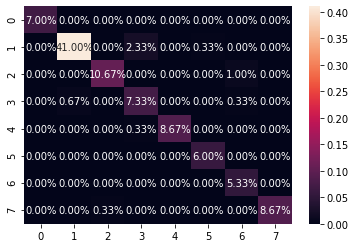

In [ ]:
cf_matrix = confusion_matrix(ground_truthVal,predVal)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')
print("Accuracy :", accuracy_score(ground_truthVal, predVal))

In [ ]:
model.to('cpu')
model.eval()
predVal = []
ground_truthVal = []

for images, labels in test_loader:
  res = torch.zeros(8)
  img1 = images[:,:,0:230,3:233]
  res = res + model(img1)
  img2 = images[:,:,230:460,3:233]
  res = res + model(img2)

  img3 = images[:,:,0:230,236:466]
  res = res + model(img3)
  img4 = images[:,:,230:460,236:466]
  res = res + model(img4)

  img5 = images[:,:,0:230,469:699]
  res = res + model(img5)
  img6 = images[:,:,230:460,469:699]
  res = res + model(img6)

  predicted = torch.argmax(res)
  predVal.extend(predicted.detach().cpu().numpy().flatten().tolist())
  ground_truthVal.extend(labels.detach().cpu().numpy().flatten().tolist())

print(confusion_matrix(ground_truthVal,predVal))
print(accuracy_score(ground_truthVal,predVal))

[[ 21   0   0   0   0   0   0   0]
 [  0 123   0   7   0   1   0   0]
 [  0   0  35   0   0   0   0   0]
 [  0   2   0  23   0   0   0   0]
 [  0   0   0   0  27   0   0   0]
 [  0   0   0   0   0  18   0   0]
 [  0   0   0   0   0   0  16   0]
 [  0   0   0   0   0   0   0  27]]
0.9666666666666667


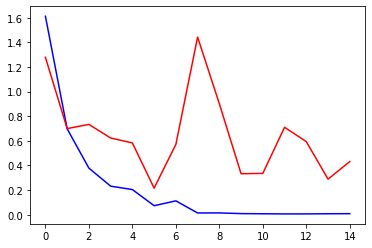

In [ ]:
plt.plot(np.arange(len(val_acc)),val_loss,color="blue")
plt.plot(np.arange(len(val_acc)),train_loss,color="red")

# ResNet50

In [ ]:
from torchvision.models import resnet50

model = resnet50(pretrained=True)
model.fc = nn.Linear(2048, 8)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.02)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

val_acc = []
train_acc = []
train_loss = []
val_loss = []

num_epochs = 15
for i in range(num_epochs):
  model.train()
  ground_truthVal = []
  predVal = []
  c = 0
  for images, labels in train_loader:
        predTrain = []
        ground_truthTrain = []
        images, labels = images.float().to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)

        loss = loss_fn(outputs.to(device), labels.type(torch.LongTensor).to(device))
        loss.backward()
        optimizer.step()

        predicted = torch.argmax(outputs,dim=1)
        predTrain.extend(predicted.detach().cpu().numpy().flatten().tolist())
        ground_truthTrain.extend(labels.detach().cpu().numpy().flatten().tolist())

        c+=1
        if c%10 == 0:
          accuracy = accuracy_score(ground_truthTrain, predTrain)
          print('Epoch: {}. Loss: {}. Accuracy on trainset: {}'.format(i, loss.item(), accuracy))
  train_loss.append(loss.item())
  accuracy = accuracy_score(ground_truthTrain, predTrain)
  train_acc.append(accuracy)
  for images, labels in validation_loader:#validation
      model.eval()
      with torch.no_grad():
        images, labels = images.float().to(device), labels.to(device)

        outputs = model(images)

        predicted = torch.argmax(outputs,dim=1)
        predVal.extend(predicted.detach().cpu().numpy().flatten().tolist())
        ground_truthVal.extend(labels.detach().cpu().numpy().flatten().tolist())
      
  print(confusion_matrix(ground_truthVal,predVal))
  loss = loss_fn(outputs.to(device), labels.type(torch.LongTensor).to(device))
  val_loss.append(loss.item())
  accuracy = accuracy_score(ground_truthVal, predVal)
  val_acc.append(accuracy)
  print('Accuracy in validation: {}'.format(accuracy))
  exp_lr_scheduler.step()

torch.save(model.state_dict(),"./drive/MyDrive/8CResNet50" )

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0. Loss: 1.9749482870101929. Accuracy on trainset: 0.25
Epoch: 0. Loss: 1.944485068321228. Accuracy on trainset: 0.25
Epoch: 0. Loss: 1.753204584121704. Accuracy on trainset: 0.53125
Epoch: 0. Loss: 1.5728347301483154. Accuracy on trainset: 0.46875
Epoch: 0. Loss: 1.3353887796401978. Accuracy on trainset: 0.59375
[[10  1  0  1  0  3  5  1]
 [ 0 72  0 12  0 29  9  9]
 [ 0  3  0  0  0  6 21  5]
 [ 1  1  0 19  1  2  1  0]
 [ 5  3  0  3  4 10  1  1]
 [ 0  0  0  0  0 14  2  2]
 [ 0  0  0  0  0  1 15  0]
 [ 0  2  0  0  0  3  3 19]]
Accuracy in validation: 0.51
Epoch: 1. Loss: 1.2926017045974731. Accuracy on trainset: 0.5
Epoch: 1. Loss: 1.052337646484375. Accuracy on trainset: 0.65625
Epoch: 1. Loss: 1.0902773141860962. Accuracy on trainset: 0.59375
Epoch: 1. Loss: 0.9549510478973389. Accuracy on trainset: 0.65625
Epoch: 1. Loss: 0.8945989012718201. Accuracy on trainset: 0.75
[[ 9  0  1  3  4  2  2  0]
 [ 0 63  1 26  6 17  2 16]
 [ 0  1 22  0  2  1  8  1]
 [ 0  1  0 21  1  1  1  0]
 [

Accuracy : 0.9166666666666666


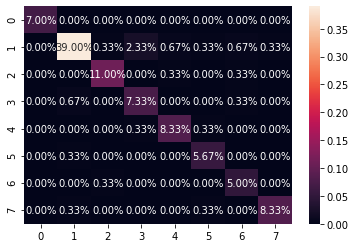

In [ ]:
import seaborn as sns
cf_matrix = confusion_matrix(ground_truthVal,predVal)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')
print("Accuracy :", accuracy_score(ground_truthVal, predVal))

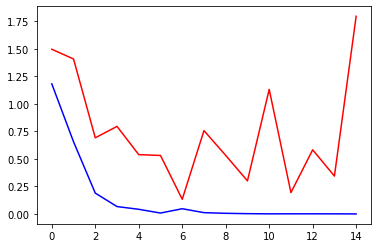

In [ ]:
plt.plot(np.arange(len(val_acc)),val_loss,color="blue")
plt.plot(np.arange(len(val_acc)),train_loss,color="red")

In [ ]:
model.to('cpu')
model.eval()
predVal = []
ground_truthVal = []

for images, labels in test_loader:
  res = torch.zeros(8)
  img1 = images[:,:,0:230,3:233]
  res = res + model(img1)
  img2 = images[:,:,230:460,3:233]
  res = res + model(img2)

  img3 = images[:,:,0:230,236:466]
  res = res + model(img3)
  img4 = images[:,:,230:460,236:466]
  res = res + model(img4)

  img5 = images[:,:,0:230,469:699]
  res = res + model(img5)
  img6 = images[:,:,230:460,469:699]
  res = res + model(img6)

  predicted = torch.argmax(res)
  predVal.extend(predicted.detach().cpu().numpy().flatten().tolist())
  ground_truthVal.extend(labels.detach().cpu().numpy().flatten().tolist())

print(confusion_matrix(ground_truthVal,predVal))
print(accuracy_score(ground_truthVal,predVal))

[[ 21   0   0   0   0   0   0   0]
 [  0 121   0   7   2   1   0   0]
 [  0   0  34   0   0   0   1   0]
 [  0   1   0  23   1   0   0   0]
 [  0   0   0   0  27   0   0   0]
 [  0   0   0   0   0  18   0   0]
 [  0   0   1   0   0   0  15   0]
 [  0   1   0   0   0   0   0  26]]
0.95
